# IMPORTS

In [1]:
!pip install -r requirements.txt
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu
!pip install transformers torch sentencepiece


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://download.pytorch.org/whl/nightly/cpu

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
from prophet import Prophet
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModel
import torch

import xgboost as xgb
import lightgbm as lgb

/Users/nathancarey/ecom/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# DATA READ

In [3]:

df_petrovich = pd.read_parquet('data/saturn_petrovich.parquet', engine='pyarrow')
df_leroy = pd.read_parquet('data/saturn_leroy.parquet', engine='pyarrow')
df_vi = pd.read_parquet('data/vi.parquet', engine='pyarrow')


**Filtering for the category of interest**

In [93]:
df_built = df_petrovich[df_petrovich['category_1'] == 'Стройматериалы']
category_with_price_count = df_built[df_built['our_price'].notna()].shape[0]
print("Number of rows corresponding to category_1 'Стройматериалы' with 'our_price' as a value:", category_with_price_count)


Number of rows corresponding to category_1 'Стройматериалы' with 'our_price' as a value: 28943


In [94]:
# The groupby operation ensures that the price lag calculations are applied only within the same SKU group.
df_built['price_lag_1'] = df_built.groupby('sku')['price'].shift(1)
df_built['price_lag_2'] = df_built.groupby('sku')['price'].shift(2)
df_built['price_lag_3'] = df_built.groupby('sku')['price'].shift(3)

/var/folders/zc/5d6j4pzj2wz21d9qzfwd9q8h0000gn/T/ipykernel_37455/3280225822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_built['price_lag_1'] = df_built.groupby('sku')['price'].shift(1)
/var/folders/zc/5d6j4pzj2wz21d9qzfwd9q8h0000gn/T/ipykernel_37455/3280225822.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_built['price_lag_2'] = df_built.groupby('sku')['price'].shift(2)
/var/folders/zc/5d6j4pzj2wz21d9qzfwd9q8h0000gn/T/ipykernel_37455/3280225822.py:4: SettingWithCopyWarning: 
A value is tr

# Feature Engineering

1. Encoding Ordinal match_type variable into three features 

In [95]:
df_built['No Match'] = (df_built['match_type'] == 0).astype(int)
df_built['100% Match'] = (df_built['match_type'] == 1).astype(int)
df_built['Exclusive'] = (df_built['match_type'] == 2).astype(int)

print("Count of No Match:", df_built['No Match'].sum())
print("Count of 100% Match:", df_built['100% Match'].sum())
print("Count of Exclusive:", df_built['Exclusive'].sum())


Count of No Match: 118708
Count of 100% Match: 37670
Count of Exclusive: 1062


/var/folders/zc/5d6j4pzj2wz21d9qzfwd9q8h0000gn/T/ipykernel_37455/1203702939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_built['No Match'] = (df_built['match_type'] == 0).astype(int)
/var/folders/zc/5d6j4pzj2wz21d9qzfwd9q8h0000gn/T/ipykernel_37455/1203702939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_built['100% Match'] = (df_built['match_type'] == 1).astype(int)
/var/folders/zc/5d6j4pzj2wz21d9qzfwd9q8h0000gn/T/ipykernel_37455/1203702939.py:3: SettingWithCopyWarning: 
A value is trying

In [96]:
# Define the status mapping
status_mapping = {
    2: "on_order",
    1: "in_stock",
    3: "expected",
    4: "status_not_defined",
    0: "out_of_stock"
}

# Map the status column to the new feature names
df_built['status'] = df_built['status'].map(status_mapping)

# One-hot encode the 'status' column, preserving other columns
df_built = pd.get_dummies(df_built, columns=['status'], prefix='', prefix_sep='')

/var/folders/zc/5d6j4pzj2wz21d9qzfwd9q8h0000gn/T/ipykernel_37455/1231935835.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_built['status'] = df_built['status'].map(status_mapping)


**Translating the categories**

using https://nllb.metademolab.com
https://huggingface.co/docs/transformers/main/en/model_doc/nllb#nllb

**Embedding the categories**

using https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

In [97]:
translation_model_name = "Helsinki-NLP/opus-mt-ru-en"
translation_tokenizer = AutoTokenizer.from_pretrained(translation_model_name)
translation_model = AutoModelForSeq2SeqLM.from_pretrained(translation_model_name)

embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedding_tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
embedding_model = AutoModel.from_pretrained(embedding_model_name)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA (GPU) for computation.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon) for computation.")
else:
    device = torch.device("cpu")
    print("Using CPU for computation.")

translation_model = translation_model.to(device)
embedding_model = embedding_model.to(device)

def batch_translate(texts, batch_size=16):
    translations = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        # Ensure batch is a list of non-empty strings
        batch = [text for text in batch if text.strip()]
        if not batch:
            continue
        inputs = translation_tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        target_lang_id = translation_tokenizer.convert_tokens_to_ids("eng_Latn")
        translated_tokens = translation_model.generate(
            **inputs,
            forced_bos_token_id=target_lang_id,
            max_length=100,
            num_beams=4,
            early_stopping=True
        )
        outputs = translation_tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
        translations.extend(outputs)
    return translations

# Batch embedding function
def batch_compute_embeddings(text_list, batch_size=64):
    embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        inputs = embedding_tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = embedding_model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
            embeddings.extend(batch_embeddings.cpu().numpy())
    return embeddings



/Users/nathancarey/ecom/myenv/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Using MPS (Apple Silicon) for computation.


**Columns to translate (Number of categories)**

In [98]:
columns_to_translate = ['category_1', 'category_2', 'category_3', 'category_4', 'category_5']

**Dataframe Class to tokenise -> Translate -> Embed**

In [99]:
class DataFrameProcessor:
    def __init__(self, df, columns, tokenizer, translator, embedder):
        self.df = df
        self.columns = columns
        self.tokenizer = tokenizer
        self.translator = translator
        self.embedder = embedder
        self.hash_tables = {}
        self.embedding_tables = {}

    def process(self):
        for col in self.columns:
            self._process_column(col)
        self._apply_embeddings()
        return self.df  # Ensure the DataFrame is returned

    def _process_column(self, col):
        unique_values = self.df[col].dropna().unique()
        unique_values = [str(value) for value in unique_values if str(value).strip()]

        # Tokenize
        inputs = self.tokenizer(unique_values, return_tensors="pt", padding=True, truncation=True)

        # Translate
        translations = self.translator(unique_values)

        # Embed
        embeddings = self.embedder(translations)

        # Create hash and embedding tables
        self.hash_tables[col] = dict(zip(unique_values, translations))
        self.embedding_tables[col] = dict(zip(translations, embeddings))

    def _apply_embeddings(self):
        self.df['embeddings'] = self.df.apply(self._map_to_embeddings, axis=1)

    def _map_to_embeddings(self, row):
        embedding_size = 384
        embeddings = []
        for col in self.columns:
            value = row[col]
            translation = self.hash_tables[col].get(value, None)
            if translation:
                embedding = self.embedding_tables[col].get(translation, None)
                if embedding is not None:
                    embeddings.extend(embedding)
                else:
                    embeddings.extend([0] * embedding_size)
            else:
                embeddings.extend([0] * embedding_size)
        return np.array(embeddings)

**Initialize and process the DataFrame**

In [100]:

# Initialize and process the DataFrame
processor = DataFrameProcessor(df_built, columns_to_translate, translation_tokenizer, batch_translate, batch_compute_embeddings)
df_built_with_embeddings = processor.process()  # Assign the returned DataFrame

# Check if the 'embeddings' column was created
if 'embeddings' in df_built_with_embeddings.columns:
    print("The 'embeddings' column was successfully created.")
else:
    print("The 'embeddings' column was not created.")

The 'embeddings' column was successfully created.


In [101]:
embeddings_expanded = np.vstack(df_built_with_embeddings['embeddings'].values)
embedding_columns = [f'embedding_{i}' for i in range(embeddings_expanded.shape[1])]
df_embeddings_expanded = pd.DataFrame(embeddings_expanded, columns=embedding_columns)

# Combine with other features
df_embeddings_expanded = pd.concat([df_built_with_embeddings.drop(columns=['embeddings']), df_embeddings_expanded], axis=1)

In [102]:
df_embeddings_expanded.head()

,match_type,category_1,category_2,category_3,category_4,category_5,sku,brand,our_price,price,...,embedding_1910,embedding_1911,embedding_1912,embedding_1913,embedding_1914,embedding_1915,embedding_1916,embedding_1917,embedding_1918,embedding_1919
0,1.0,Стройматериалы,"Кровля, водосточные системы",Гибкая черепица и комплектующие,Комплектующие для гибкой черепицы,None,600877_м2,ТЕХНОНИКОЛЬ,2049.0,137.940002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,Стройматериалы,"Кровля, водосточные системы",Профнастил и оцинкованные листы,Профнастил и комплектующие,None,106643_м2,None,NaN,673.469971,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,Стройматериалы,"Кровля, водосточные системы",Профнастил и оцинкованные листы,Профнастил и комплектующие,None,106644_м2,КОРИЧНЕВЫЙ,NaN,639.130005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,Стройматериалы,"Кровля, водосточные системы",Профнастил и оцинкованные листы,Профнастил и комплектующие,None,143965_м2,None,NaN,630.320007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,Стройматериалы,"Кровля, водосточные системы",Профнастил и оцинкованные листы,Профнастил и комплектующие,None,106642_м2,None,NaN,543.039978,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# Map True and False to 1 and 0 in the specified columns
columns_to_map = ['expected', 'in_stock', 'on_order', 'out_of_stock', 'status_not_defined']
df_built[columns_to_map] = df_built[columns_to_map].astype(int)

We have too many brands to do categorical encoding. Will use target (mean) encoding, replacing the brand with the mean price of products of that brand as it will directly link brand to the target.

In [104]:
# Target (mean) encoding for the 'brand' column
brand_mean_price = df_built.groupby('brand')['price'].mean()
df_built['brand_mean_price'] = df_built['brand'].map(brand_mean_price)

# Dropping the original 'brand' column as it is now encoded
df_built = df_built.drop(columns=['brand'])

**Create the Default SKU Flag and extract the SKU suffix**

In [105]:
df_built['sku_suffix'] = df_built['sku'].str.extract(r'_(\w+)$')[0]

df_built['default_sku'] = df_built['sku_suffix'].isnull().astype(int)

In [106]:
unique_sku_suffix_count = df_built['sku_suffix'].nunique()
print(f"Number of unique SKU suffix values: {unique_sku_suffix_count}")

# One hot encode the sku_suffix column
sku_suffix_dummies = pd.get_dummies(df_built['sku_suffix'], prefix='sku_suffix')
df_built = pd.concat([df_built, sku_suffix_dummies], axis=1)

suffix_colums = ['sku_suffix_компл', 'sku_suffix_м2', 'sku_suffix_м3', 'sku_suffix_паллета', 'sku_suffix_рул', 'sku_suffix_рулон','sku_suffix_упак', 'sku_suffix_шт' ]
df_built[suffix_colums] = df_built[suffix_colums].astype(int)

Number of unique SKU suffix values: 8


In [107]:
# Dropping the original 'sku_suffix' column as it is now encoded
df_built = df_built.drop(columns=['sku_suffix'])

In [108]:
df_built['sku'] = df_built['sku'].str.extract(r'^(\d+)_')[0]

In [109]:
df_built = df_built.drop(columns=['category_5', 'category_4', 'category_3', 'category_2'])

df_built = df_built.drop(columns=['city', 'match_type', 'category_1', 'competitor'])

In [110]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings_expanded)

pca = PCA(n_components=0.95)
reduced_embeddings = pca.fit_transform(scaled_embeddings)

# Create DataFrame for reduced embeddings
reduced_embedding_columns = [f'pca_embedding_{i}' for i in range(reduced_embeddings.shape[1])]
df_pca_embeddings = pd.DataFrame(reduced_embeddings, columns=reduced_embedding_columns)

# Combine with original DataFrame
df_built = df_built.reset_index(drop=True)
df_built_with_pca = pd.concat([df_built, df_pca_embeddings], axis=1)


In [111]:
df_built_with_pca['embeddings'].head()

0    [-0.5306603908538818, 0.23424945771694183, -0....
1    [-0.5306603908538818, 0.23424945771694183, -0....
2    [-0.5306603908538818, 0.23424945771694183, -0....
3    [-0.5306603908538818, 0.23424945771694183, -0....
4    [-0.5306603908538818, 0.23424945771694183, -0....
Name: embeddings, dtype: object

In [112]:
# Convert float64 columns to float32 for computational efficiency
float64_cols = df_built_with_pca.select_dtypes(include=['float64']).columns
df_built_with_pca[float64_cols] = df_built_with_pca[float64_cols].astype('float32')


In [113]:
df_built_with_pca.head()

,sku,our_price,price,price_before_discount,date,price_lag_1,price_lag_2,price_lag_3,No Match,100% Match,...,pca_embedding_81,pca_embedding_82,pca_embedding_83,pca_embedding_84,pca_embedding_85,pca_embedding_86,pca_embedding_87,pca_embedding_88,pca_embedding_89,pca_embedding_90
0,600877,2049.0,137.940002,NaN,2024-10-07,NaN,NaN,NaN,0,1,...,0.134997,-2.748105,0.616741,-0.634544,1.255837,1.043900,-0.186704,1.254425,0.212575,0.661735
1,106643,NaN,673.469971,NaN,2024-10-07,NaN,NaN,NaN,0,1,...,-0.479697,0.590059,1.150432,0.747121,-0.501456,-0.279319,0.110671,0.737475,-1.124214,-0.823129
2,106644,NaN,639.130005,NaN,2024-10-07,NaN,NaN,NaN,0,1,...,-0.479697,0.590059,1.150432,0.747121,-0.501456,-0.279319,0.110671,0.737475,-1.124214,-0.823129
3,143965,NaN,630.320007,NaN,2024-10-07,NaN,NaN,NaN,0,1,...,-0.479697,0.590059,1.150432,0.747121,-0.501456,-0.279319,0.110671,0.737475,-1.124214,-0.823129
4,106642,NaN,543.039978,NaN,2024-10-07,NaN,NaN,NaN,0,1,...,-0.479697,0.590059,1.150432,0.747121,-0.501456,-0.279319,0.110671,0.737475,-1.124214,-0.823129


In [114]:
df_built_with_pca['sku'] = df_built_with_pca['sku'].astype('int32')

# Convert int64 columns to int8 for computational efficiency
int64_cols = df_built_with_pca.select_dtypes(include=['int64']).columns
df_built_with_pca[int64_cols] = df_built_with_pca[int64_cols].astype('int8')




**Convert Datetime to Dates**

In [115]:
df_built_with_pca['date'] = pd.to_datetime(df_built_with_pca['date'], errors='coerce')

df_built_with_pca['year'] = df_built_with_pca['date'].dt.year
df_built_with_pca['month'] = df_built_with_pca['date'].dt.month
df_built_with_pca['day'] = df_built_with_pca['date'].dt.day
df_built_with_pca['day_of_week'] = df_built_with_pca['date'].dt.dayofweek

# Optionally, calculate elapsed days from the first date in the dataset
df_built_with_pca['days_since_start'] = (df_built_with_pca['date'] - df_built_with_pca['date'].min()).dt.days

# Verify the new features
print(df_built_with_pca[['date', 'year', 'month', 'day', 'day_of_week', 'days_since_start']].head())


        date  year  month  day  day_of_week  days_since_start
0 2024-10-07  2024     10    7            0               242
1 2024-10-07  2024     10    7            0               242
2 2024-10-07  2024     10    7            0               242
3 2024-10-07  2024     10    7            0               242
4 2024-10-07  2024     10    7            0               242


/var/folders/zc/5d6j4pzj2wz21d9qzfwd9q8h0000gn/T/ipykernel_37455/1362227204.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_built_with_pca['year'] = df_built_with_pca['date'].dt.year
/var/folders/zc/5d6j4pzj2wz21d9qzfwd9q8h0000gn/T/ipykernel_37455/1362227204.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_built_with_pca['month'] = df_built_with_pca['date'].dt.month
/var/folders/zc/5d6j4pzj2wz21d9qzfwd9q8h0000gn/T/ipykernel_37455/1362227204.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

In [116]:
# Display the data types of the DataFrame to understand the features
print(df_built_with_pca.dtypes.to_string())

# Advice on using these features in a machine learning application:
# - Ensure that the target variable 'price' is not included in the feature set.
# - Use features like 'our_price', 'price_before_discount', 'brand_mean_price', and 'pca_embeddings' for predicting 'price'.
# - Convert categorical features like 'date' to numerical representations if needed.
# - Handle missing values appropriately, either by filling them or by using models that can handle NaNs.
# - Normalize or standardize features if required by the machine learning algorithm.
# - Consider feature engineering to create new features that might be useful for prediction.
# - Split the data into training and testing sets to evaluate the model's performance.
# - Use cross-validation to ensure the model generalizes well to unseen data.
# - Experiment with different algorithms like RandomForestRegressor, GradientBoostingRegressor, or neural networks to find the best model.
# - Tune hyperparameters using grid search or random search to optimize model performance.

sku                               int32
our_price                       float32
price                           float32
price_before_discount           float32
date                     datetime64[ns]
price_lag_1                     float32
price_lag_2                     float32
price_lag_3                     float32
No Match                           int8
100% Match                         int8
Exclusive                          int8
expected                           int8
in_stock                           int8
on_order                           int8
out_of_stock                       int8
status_not_defined                 int8
embeddings                       object
brand_mean_price                float32
default_sku                        int8
sku_suffix_компл                   int8
sku_suffix_м2                      int8
sku_suffix_м3                      int8
sku_suffix_паллета                 int8
sku_suffix_рул                     int8
sku_suffix_рулон                   int8


**Forecasting Features**

In [117]:


if 'our_price' in df_built_with_pca.columns:
    df_built_with_pca['our_price_ratio'] = df_built_with_pca.apply(
        lambda row: row['our_price'] / row['price'] if row['price'] != 0 else 0, axis=1
    )

threshold = 0.05  # Define a threshold for price change greater than 5%
df_built_with_pca['price_change'] = (df_built_with_pca['price'].diff().fillna(0).abs() / df_built_with_pca['price'].shift(1).fillna(1)) > threshold

df_built_with_pca['price_change'] = df_built_with_pca['price_change'].astype('int8')

/var/folders/zc/5d6j4pzj2wz21d9qzfwd9q8h0000gn/T/ipykernel_37455/3438025519.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_built_with_pca['our_price_ratio'] = df_built_with_pca.apply(
/var/folders/zc/5d6j4pzj2wz21d9qzfwd9q8h0000gn/T/ipykernel_37455/3438025519.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_built_with_pca['price_change'] = (df_built_with_pca['price'].diff().fillna(0).abs() / df_built_with_pca['price'].shift(1).fillna(1)) > threshold


**EDA of features engineered**

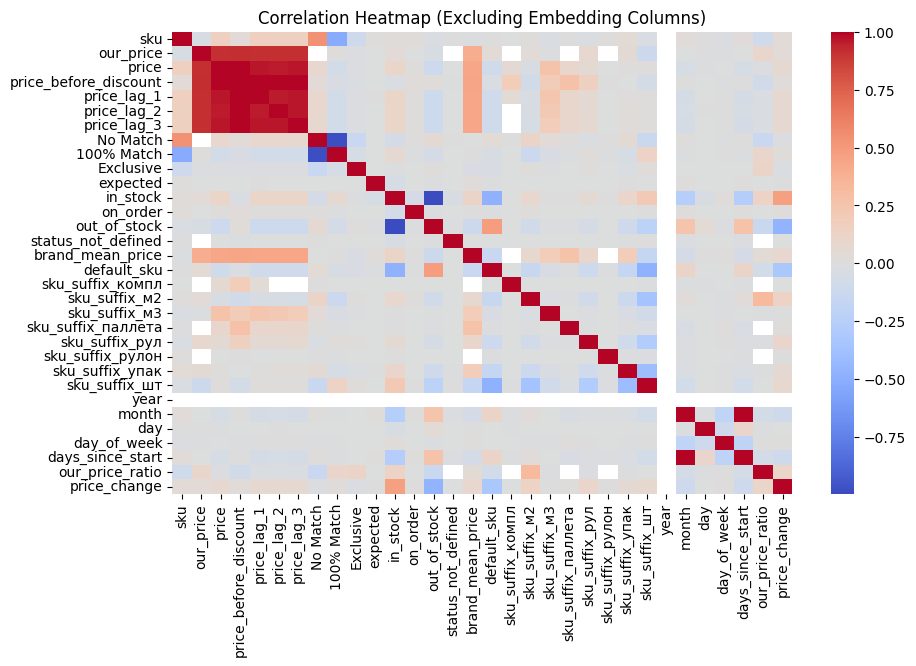

In [118]:
numeric_cols = df_built_with_pca.select_dtypes(include=['number']).columns

non_embedding_cols = [col for col in numeric_cols if not col.startswith("pca_embedding")]

correlation_matrix = df_built_with_pca[non_embedding_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, cbar=True, fmt=".2f")
plt.title("Correlation Heatmap (Excluding Embedding Columns)")
plt.show()

In [119]:
df_built_with_pca = df_built_with_pca.drop(columns=['date'])

In [120]:
df_built_with_pca = df_built_with_pca.drop(columns=['embeddings'])

In [121]:
df_built_with_pca['month'] = df_built_with_pca['month'].dt.month

AttributeError: Can only use .dt accessor with datetimelike values

In [59]:
# Display the count of NaN values for each column in the DataFrame and their types
nan_counts = df_built_with_pca.isna().sum()
nan_types = df_built_with_pca.dtypes
print("NaN counts and types per column:")
for col in nan_counts.index:
    print(f"{col}: {nan_counts[col]} (type: {nan_types[col]})")


NaN counts and types per column:
sku: 0 (type: int32)
our_price: 124760 (type: float32)
price: 0 (type: float32)
price_before_discount: 85311 (type: float32)
price_lag_1: 6647 (type: float32)
price_lag_2: 13192 (type: float32)
price_lag_3: 19621 (type: float32)
No Match: 0 (type: int8)
100% Match: 0 (type: int8)
Exclusive: 0 (type: int8)
expected: 0 (type: int8)
in_stock: 0 (type: int8)
on_order: 0 (type: int8)
out_of_stock: 0 (type: int8)
status_not_defined: 0 (type: int8)
brand_mean_price: 99094 (type: float32)
default_sku: 0 (type: int8)
sku_suffix_компл: 0 (type: int8)
sku_suffix_м2: 0 (type: int8)
sku_suffix_м3: 0 (type: int8)
sku_suffix_паллета: 0 (type: int8)
sku_suffix_рул: 0 (type: int8)
sku_suffix_рулон: 0 (type: int8)
sku_suffix_упак: 0 (type: int8)
sku_suffix_шт: 0 (type: int8)
pca_embedding_0: 0 (type: float32)
pca_embedding_1: 0 (type: float32)
pca_embedding_2: 0 (type: float32)
pca_embedding_3: 0 (type: float32)
pca_embedding_4: 0 (type: float32)
pca_embedding_5: 0 (type

In [ ]:
# Plot percentage of missing values over time for the top 7 columns with the most missingness
top_7_missing_cols = df_built_with_pca.isna().sum().sort_values(ascending=False).head(7).index

# Extract the month from the date column
df_built_with_pca['month'] = df_built_with_pca['date'].dt.to_period('M')

# Filter data to include only up to October
df_built_with_pca = df_built_with_pca[df_built_with_pca['month'] <= '2024-10']

# Group by month and calculate the percentage of missing values per month relative to the entire DataFrame
total_missing_values = df_built_with_pca.isna().sum().sum()
monthly_missing_percentage = df_built_with_pca.groupby('month')[top_7_missing_cols].apply(
    lambda x: (x.isna().sum() / total_missing_values * 100)
)

plt.figure(figsize=(12, 8))
plt.stackplot(
    monthly_missing_percentage.index.to_timestamp(),
    [monthly_missing_percentage[col] for col in top_7_missing_cols],
    labels=top_7_missing_cols,
    alpha=0.5
)

plt.xlabel('Date')
plt.ylabel('Percentage of Missing Values (Relative to Entire DataFrame)')
plt.title('Percentage of Missing Values Over Time')
plt.legend(loc='upper left')
plt.show()


In [61]:
X = df_built_with_pca.drop(columns=['price'])  # Replace 'target_column' with the actual target column name
y = df_built_with_pca['price']  # Replace 'target_column' with the actual target column name

# Split the data into train, validation, and test sets (65-20-15 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.35, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4286, random_state=42)  # 0.4286 * 0.35 ≈ 0.15

In [ ]:
#overfitting on price_lag_1...

X_train = X_train.drop(columns=['price_lag_1'])
X_val = X_val.drop(columns=['price_lag_1'])
X_test = X_test.drop(columns=['price_lag_1'])

In [ ]:
# Determine which columns to scale based on their range of values and best practices
numerical_columns = X_train.select_dtypes(include=[np.number]).columns

# Calculate the range, mean, and standard deviation of values for each numerical column
column_stats = X_train[numerical_columns].agg(['min', 'max', 'mean', 'std'])

# Define thresholds for scaling based on range and standard deviation
range_threshold = 1
std_threshold = 0.5

# Select columns that need scaling based on range or standard deviation
columns_to_scale = column_stats.loc['max'] - column_stats.loc['min'] > range_threshold
columns_to_scale |= column_stats.loc['std'] > std_threshold
columns_to_scale = columns_to_scale[columns_to_scale].index.tolist()

# Print the columns that will be scaled
print("Columns to be scaled:", columns_to_scale)

# Apply scaling only to the selected columns
scaler = StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_val[columns_to_scale] = scaler.transform(X_val[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])



In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Suggest hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }
    
    model = xgb.XGBRegressor(**param, random_state=42)
    
    # Cross-validation
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
    return -scores.mean()  # Optuna minimizes by default

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best parameters
print("Best parameters:", study.best_params)

# Train the model with the best parameters
best_model = xgb.XGBRegressor(**study.best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Evaluate performance
print("Best Model Performance:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))



In [71]:
target_std = y.std()
target_mean = y.mean()
print("Standard Deviation of Target:", target_std)
print("Mean of Target:", target_mean)


Standard Deviation of Target: 7077.2407
Mean of Target: 2368.1804


In [79]:
# Baseline XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Model Performance:")
print("MSE:", mse_xgb)
print("MAE:", mae_xgb)
print("R2:", r2_xgb)

# Baseline Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Model Performance:")
print("MSE:", mse_rf)
print("MAE:", mae_rf)
print("R2:", r2_rf)


XGBoost Model Performance:
MSE: 2220070.0
MAE: 246.08408
R2: 0.9508295655250549

Random Forest Model Performance:
MSE: 1353058.4427524041
MAE: 128.76077283090706
R2: 0.9700322584589514


How many outliers are there in target.

**Interpreting the results**

Scale of Error

Standard deviation of target: 7077.24

Mean of target: 2368.18

Model MSE: 1782692.4

Model RMSE: √1782692.4 ≈ 1335.98

The RMSE (1335.98) is much smaller than the target’s standard deviation (7077.24), indicating that the model performs well in reducing the natural 
variability of the data.


The R² score (0.9605) indicates that the model explains ~96% of the variance in the target variable. This is a strong indicator of good performance.

**Ensemble Method Selected- Stacking**

In [76]:
# Base models
base_models = [
    ('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=42))
]

# Meta-learner
meta_model = Ridge()

# Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Train the stacking regressor
stacking_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_stack = stacking_model.predict(X_test)

# Metrics
mse_stack = mean_squared_error(y_test, y_pred_stack)
mae_stack = mean_absolute_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

print("Stacking Model Performance:")
print("MSE:", mse_stack)
print("MAE:", mae_stack)
print("R2:", r2_stack)




[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22055
[LightGBM] [Info] Number of data points in the train set: 99327, number of used features: 117
[LightGBM] [Info] Start training from score 2395.730512
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22183
[LightGBM] [Info] Number of data points in the train set: 79461, number of used features: 117
[LightGBM] [Info] Start training from score 2402.097354
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Top 20 Feature Importances for xgb:
              Feature  Importance
3         price_lag_2    0.122941
17      sku_suffix_м3    0.099059
65   pca_embedding_42    0.078013
42   pca_embedding_19    0.074945
25    pca_embedding_2    0.065426
107  pca_embedding_84    0.064853
11       out_of_stock    0.056351
38   pca_embedding_15    0.053912
15   sku_suffix_компл    0.049396
21    sku_suffix_упак    0.033075
96   pca_embedding_73    0.028314
75   pca_embedding_52    0.027687
4         price_lag_3    0.026846
33   pca_embedding_10    0.017493
105  pca_embedding_82    0.015064
108  pca_embedding_85    0.014877
29    pca_embedding_6    0.013353
0                 sku    0.010700
26    pca_embedding_3    0.008587
92   pca_embedding_69    0.007221


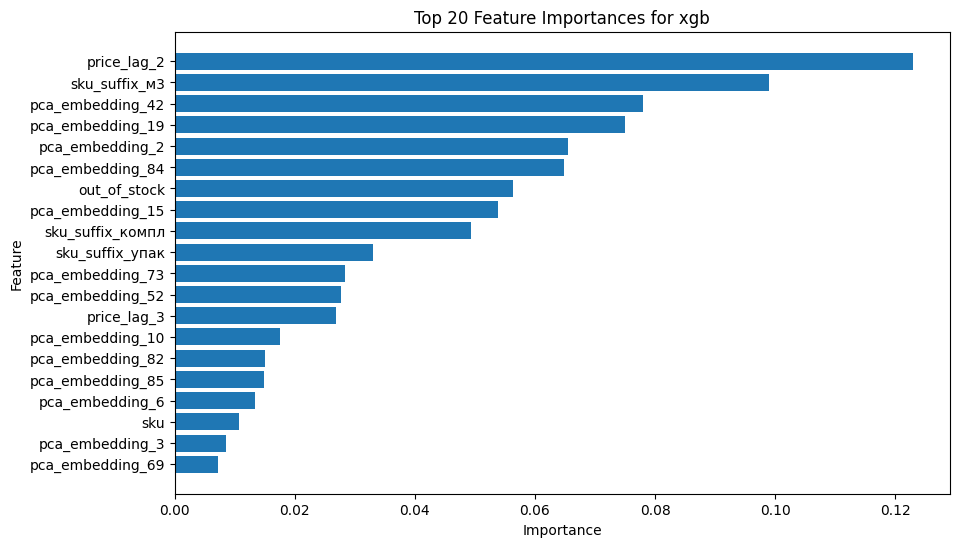

Top 20 Feature Importances for rf:
                   Feature  Importance
3              price_lag_2    0.703639
4              price_lag_3    0.067520
0                      sku    0.054970
17           sku_suffix_м3    0.031378
42        pca_embedding_19    0.020100
2    price_before_discount    0.011966
118       days_since_start    0.011019
26         pca_embedding_3    0.008508
25         pca_embedding_2    0.005448
116                    day    0.004485
37        pca_embedding_14    0.004360
40        pca_embedding_17    0.004007
61        pca_embedding_38    0.003642
82        pca_embedding_59    0.003545
33        pca_embedding_10    0.003534
16           sku_suffix_м2    0.003166
67        pca_embedding_44    0.002994
115                  month    0.002787
62        pca_embedding_39    0.002481
32         pca_embedding_9    0.002380


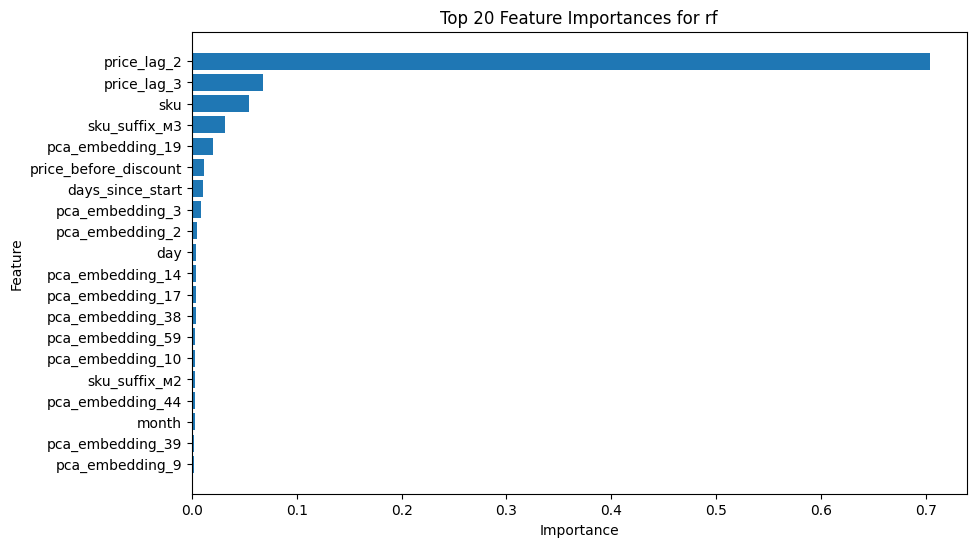

Top 20 Feature Importances for lgb:
                   Feature  Importance
0                      sku         571
3              price_lag_2         522
4              price_lag_3         264
2    price_before_discount         148
118       days_since_start         139
116                    day         112
115                  month          67
17           sku_suffix_м3          67
13        brand_mean_price          55
119        our_price_ratio          51
23         pca_embedding_0          51
26         pca_embedding_3          44
16           sku_suffix_м2          39
25         pca_embedding_2          38
1                our_price          35
42        pca_embedding_19          34
31         pca_embedding_8          28
29         pca_embedding_6          27
18      sku_suffix_паллета          26
108       pca_embedding_85          25


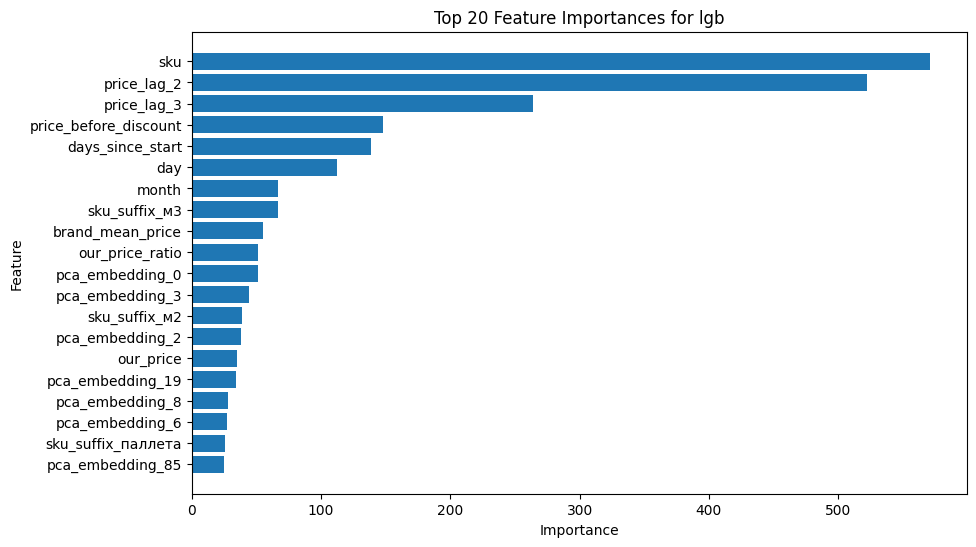

ValueError: All arrays must be of the same length

In [92]:
# Feature Importance for each base model
importances_dict = {name: np.zeros(X_train.shape[1]) for name in stacking_model.named_estimators_.keys()}

for name, model in stacking_model.named_estimators_.items():
    if hasattr(model, 'feature_importances_'):
        importances_dict[name] = model.feature_importances_

# Create DataFrames for better visualization
feature_importance_dfs = {}
for name, importances in importances_dict.items():
    feature_importance_dfs[name] = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(20)

# Display the feature importances for each model
for name, df in feature_importance_dfs.items():
    print(f"Top 20 Feature Importances for {name}:")
    print(df)
    plt.figure(figsize=(10, 6))
    plt.barh(df['Feature'], df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top 20 Feature Importances for {name}')
    plt.gca().invert_yaxis()
    plt.show()


Top 20 Feature Importances for xgb:
              Feature  Importance
3         price_lag_2    0.122941
17      sku_suffix_м3    0.099059
65   pca_embedding_42    0.078013
42   pca_embedding_19    0.074945
25    pca_embedding_2    0.065426
107  pca_embedding_84    0.064853
11       out_of_stock    0.056351
38   pca_embedding_15    0.053912
15   sku_suffix_компл    0.049396
21    sku_suffix_упак    0.033075
96   pca_embedding_73    0.028314
75   pca_embedding_52    0.027687
4         price_lag_3    0.026846
33   pca_embedding_10    0.017493
105  pca_embedding_82    0.015064
108  pca_embedding_85    0.014877
29    pca_embedding_6    0.013353
0                 sku    0.010700
26    pca_embedding_3    0.008587
92   pca_embedding_69    0.007221


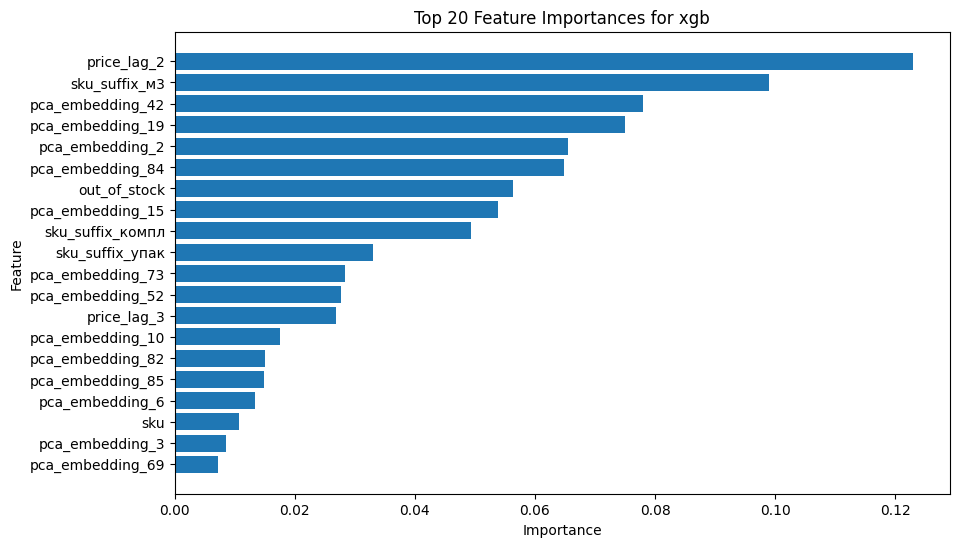

Top 20 Feature Importances for rf:
                   Feature  Importance
3              price_lag_2    0.703639
4              price_lag_3    0.067520
0                      sku    0.054970
17           sku_suffix_м3    0.031378
42        pca_embedding_19    0.020100
2    price_before_discount    0.011966
118       days_since_start    0.011019
26         pca_embedding_3    0.008508
25         pca_embedding_2    0.005448
116                    day    0.004485
37        pca_embedding_14    0.004360
40        pca_embedding_17    0.004007
61        pca_embedding_38    0.003642
82        pca_embedding_59    0.003545
33        pca_embedding_10    0.003534
16           sku_suffix_м2    0.003166
67        pca_embedding_44    0.002994
115                  month    0.002787
62        pca_embedding_39    0.002481
32         pca_embedding_9    0.002380


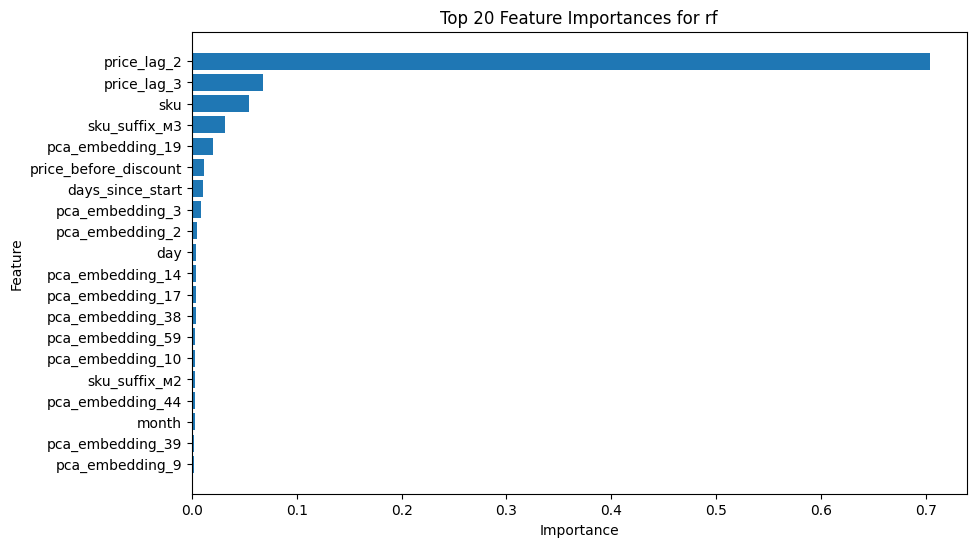

Top 20 Feature Importances for lgb:
                   Feature  Importance
0                      sku         571
3              price_lag_2         522
4              price_lag_3         264
2    price_before_discount         148
118       days_since_start         139
116                    day         112
115                  month          67
17           sku_suffix_м3          67
13        brand_mean_price          55
119        our_price_ratio          51
23         pca_embedding_0          51
26         pca_embedding_3          44
16           sku_suffix_м2          39
25         pca_embedding_2          38
1                our_price          35
42        pca_embedding_19          34
31         pca_embedding_8          28
29         pca_embedding_6          27
18      sku_suffix_паллета          26
108       pca_embedding_85          25


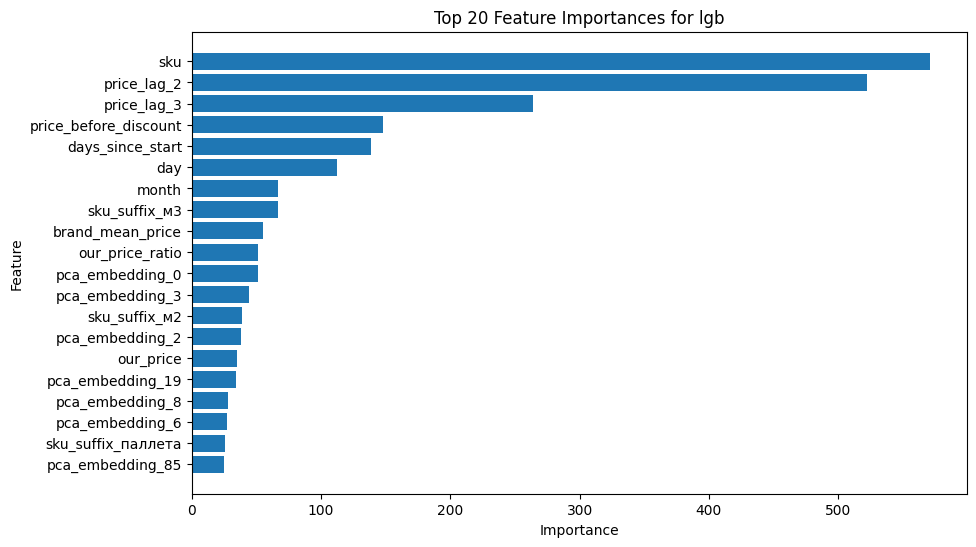

ValueError: All arrays must be of the same length

In [125]:
# Iterate over each base model
for name, model in stacking_model.named_estimators_.items():
    if hasattr(model, 'feature_importances_'):
        importances_dict[name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances_dict[name] = np.abs(model.coef_)

# Display feature importances for each base model
for name, importances in importances_dict.items():
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(20)
    
    print(f"Top 20 Feature Importances for {name}:")
    print(feature_importance_df)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top 20 Feature Importances for {name}')
    plt.gca().invert_yaxis()
    plt.show()

# If the meta-learner is a linear model, extract its coefficients
if hasattr(stacking_model.final_estimator_, 'coef_'):
    meta_importances = np.abs(stacking_model.final_estimator_.coef_)
    meta_feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': meta_importances
    }).sort_values(by='Importance', ascending=False).head(20)
    
    print("Top 20 Feature Importances for Meta-Learner:")
    print(meta_feature_importance_df)
    
    # Plot meta-learner feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(meta_feature_importance_df['Feature'], meta_feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 20 Feature Importances for Meta-Learner')
    plt.gca().invert_yaxis()
    plt.show()

MSE decreased by ~29% (1,782,692.4 → 1,258,884.03), indicating better error reduction.


MAE decreased by ~20% (195.24 → 156.83), reflecting smaller average errors.


R² increased from 0.9605 to 0.9721, meaning the stacking model explains more variance in the target variable.

Applying prediction of the price at scale and modeling scenarios. What isf the price goes up? What if it goes down? Agent 

In [91]:
single_input = [X_test.iloc[5].values]  # Use a row from your test set or create a custom feature set

# Predict
single_prediction = stacking_model.predict(single_input)
actual_price = y_test.iloc[5]
print("Predicted Price (RUB):", single_prediction[0])
print("Actual Price (RUB):", actual_price)


Predicted Price (RUB): 1696.0101673236913
Actual Price (RUB): 1695.0


/Users/nathancarey/ecom/myenv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
